In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
import os
from sys import platform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.tree import ExtraTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Some configuration for matplotlib and seaborn to look pretty
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'
sns.set_context("poster")
sns.set(rc={"figure.figsize": (18.,9.)})
sns.set_style("whitegrid")
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Instructions

1. Load the `train.csv` file
2. Explore the data, understand it
3. Process it for future training
4. Do train, test, split for your `train.csv` file
5. `fit/train` a model from your cleaned_train_df
-----
5. Load the `train.csv` file
6. Apply the same processing you did to `train.csv` into `test.csv`
7. `predict` the price for that file
8. Only keep the columns you need
9. Export
-----
10. Repeat! 🚀🔥

# Import the csv files

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Exploratory Data Analysis

In [4]:
print(df_train.shape[0])
df_train.sample()

40455


,id,carat,cut,color,clarity,depth,table,x,y,z,price
14077,14077,1.54,Very Good,G,VVS2,61.1,55.0,7.5,7.53,4.59,9.631


In [5]:
print(df_test.shape[0])
df_test.sample()

13485


,id,carat,cut,color,clarity,depth,table,x,y,z
10139,10139,0.8,Ideal,F,VS2,62.7,54.0,5.95,5.91,3.72


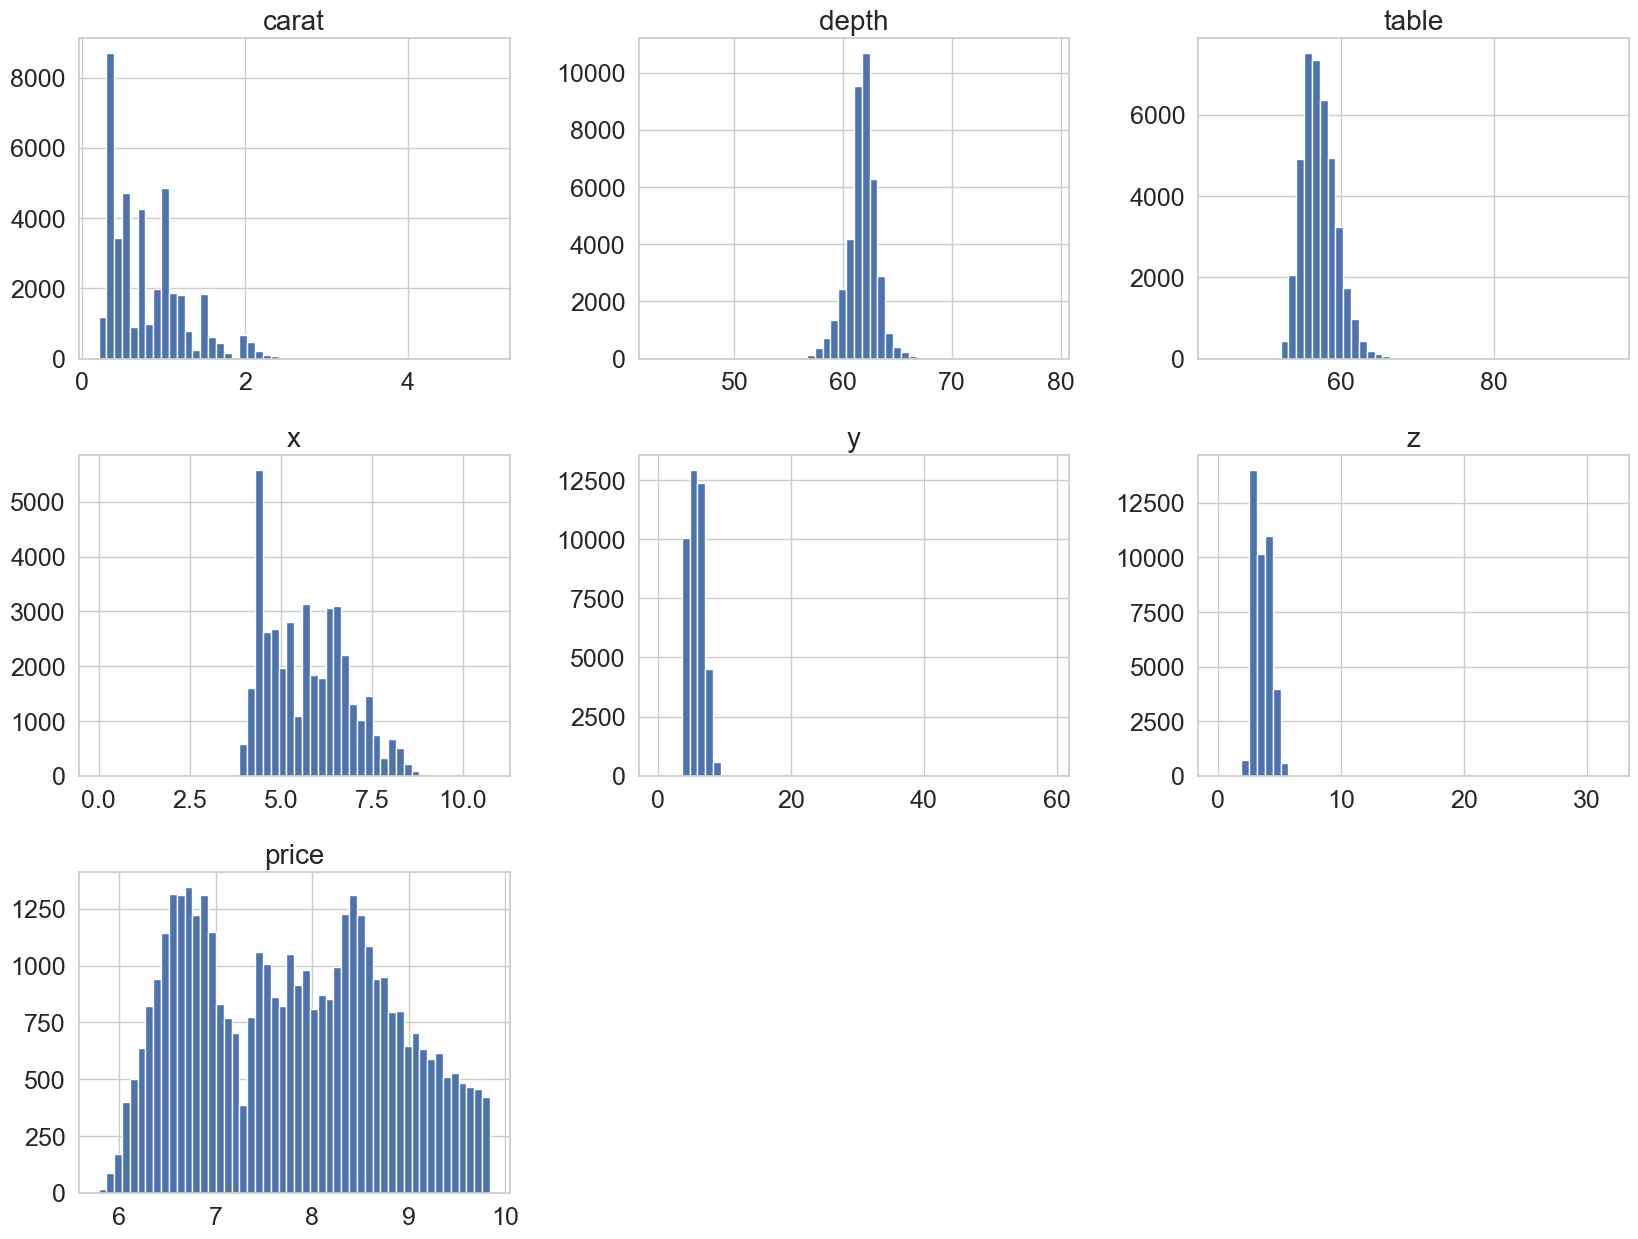

In [6]:
df_train.drop(columns=['id'], inplace=True)
df_train.hist(bins = 50, figsize = (20, 15))
plt.show()

<AxesSubplot: title={'center': 'Correlation Heatmap'}>

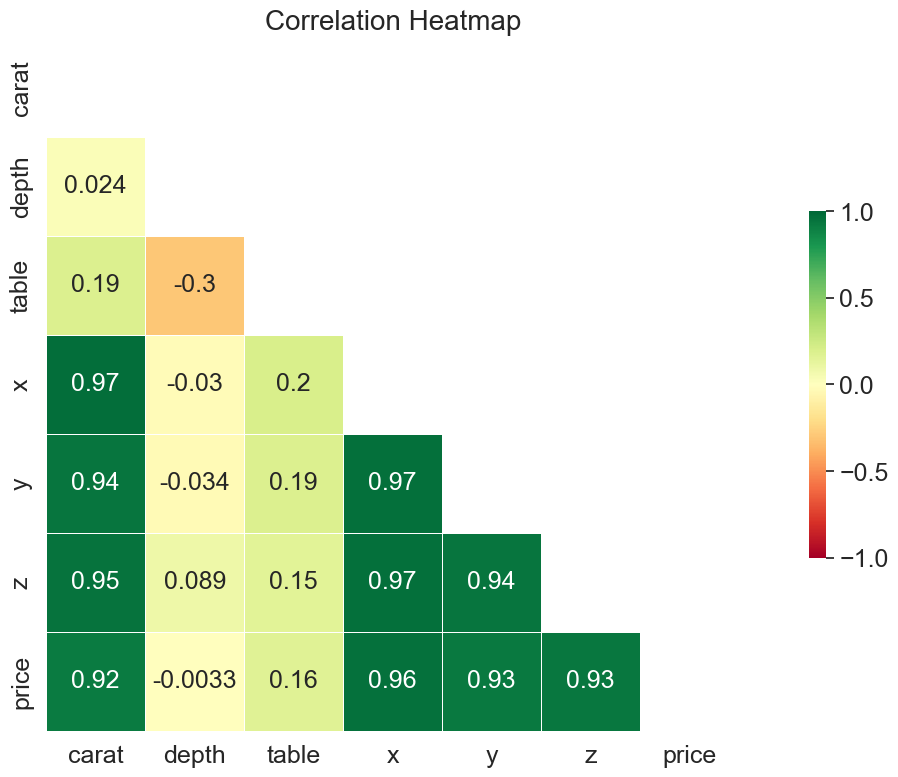

In [7]:
#Finding correlations within the df

#Set the variables
corrmat = df_train.corr()       
mask = np.triu(np.ones_like(corrmat, dtype=bool)) 
top_corr_features = corrmat.index
plt.title("Correlation Heatmap")

#Plot the heatmap
sns.heatmap(corrmat,  
            mask = mask,
            cmap='RdYlGn',
            square=True, 
            linewidth=0.5, 
            annot = True,
            vmax=1,
            vmin=-1,
            cbar_kws={"shrink": .5})

The variables x,y,z which represent the size of the diamond have high correlation among them and with carat. To avoid multicolinearity, xyz will be dropped, as if we multiply them we would get the volume which has a correlation of 1 with Carat. Table and depth are other measures of size and have almost no Weight on the predictive model if tested.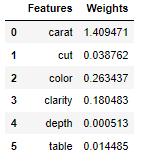

In [8]:
df_train.drop(columns=['x','y','z', 'depth', 'table'], inplace=True)
df_test.drop(columns=['x','y','z', 'depth', 'table'], inplace=True)

In [9]:
df_train.cut.value_counts()

Ideal        16230
Premium      10338
Very Good     9003
Good          3682
Fair          1202
Name: cut, dtype: int64

In [10]:
dict_cut = {
    'Ideal': 5,
    'Premium': 4,
    'Very Good': 3,
    'Good': 2,
    'Fair': 1
    }

In [11]:
df_train.cut = df_train.cut.map(dict_cut) # Map on pandas is different form map in python
df_test.cut = df_test.cut.map(dict_cut)
df_train.sample()

,carat,cut,color,clarity,price
14756,0.7,4,E,VS2,7.945


In [12]:
df_train.color.value_counts()

G    8410
E    7368
F    7182
H    6203
D    5100
I    4070
J    2122
Name: color, dtype: int64

In [13]:
dict_color = {
    'D': 7,
    'E': 6,
    'F': 5,
    'G': 4,
    'H': 3,
    'I': 2,
    'J': 1
    }

In [14]:
df_train.color = df_train.color.map(dict_color)
df_test.color = df_test.color.map(dict_color)
df_train.sample()

,carat,cut,color,clarity,price
35096,0.94,3,4,VS2,8.409


In [15]:
df_train.clarity.value_counts()

SI1     9779
VS2     9259
SI2     6921
VS1     6079
VVS2    3745
VVS1    2807
IF      1312
I1       553
Name: clarity, dtype: int64

In [16]:
dict_clarity = {
    'IF': 8,
    'VVS1': 7,
    'VVS2': 6,
    'VS1': 5,
    'VS2': 4,
    'SI1': 3,
    'SI2': 2,
    'I1': 1
    }

In [17]:
df_train.clarity = df_train.clarity.map(dict_clarity)
df_test.clarity = df_test.clarity.map(dict_clarity)
df_train.sample()

,carat,cut,color,clarity,price
31928,0.31,5,3,7,6.532


<AxesSubplot: title={'center': 'Correlation Heatmap'}>

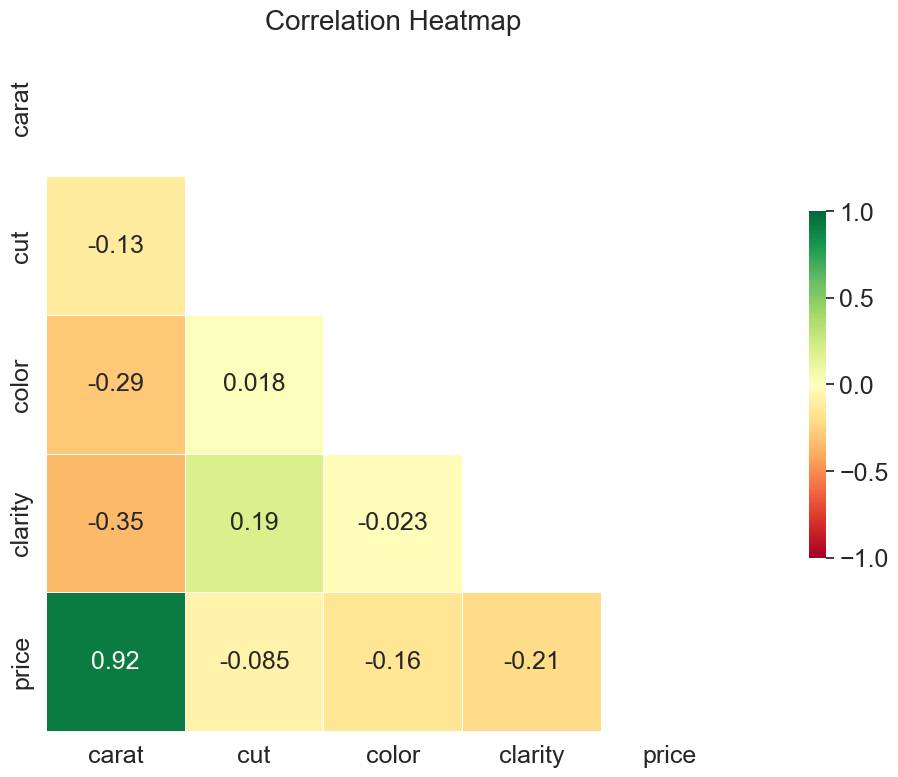

In [18]:
#Finding correlations within the df

#Set the variables
corrmat = df_train.corr()       
mask = np.triu(np.ones_like(corrmat, dtype=bool)) 
top_corr_features = corrmat.index
plt.title("Correlation Heatmap")

#Plot the heatmap
sns.heatmap(corrmat,  
            mask = mask,
            cmap='RdYlGn',
            square=True, 
            linewidth=0.5, 
            annot = True,
            vmax=1,
            vmin=-1,
            cbar_kws={"shrink": .5})

## Cleaning

Visualizing the data helps get rid of outliers which may generate noise on the model.

<AxesSubplot: xlabel='carat', ylabel='Count'>

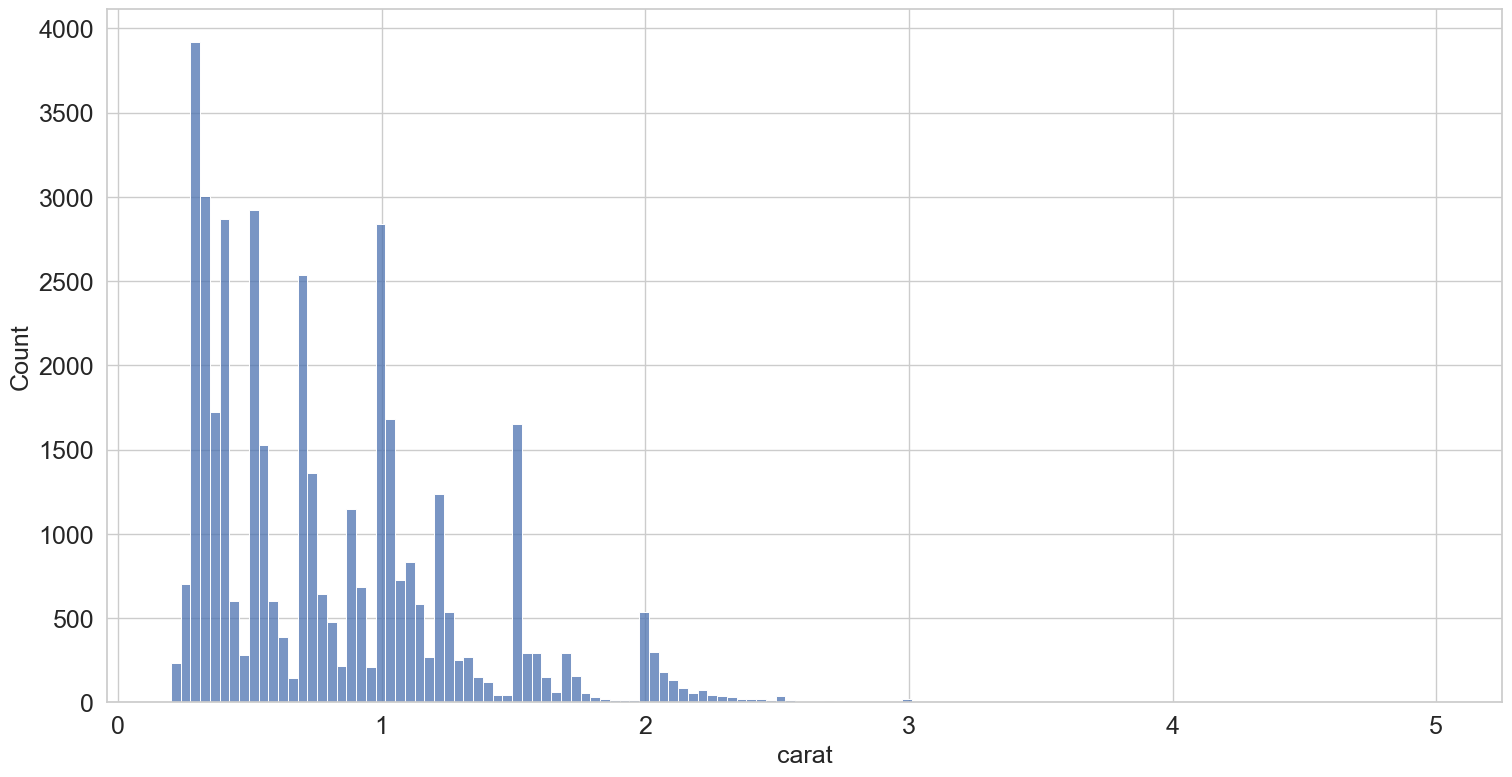

In [19]:
sns.histplot(df_train.carat)

<AxesSubplot: xlabel='carat'>

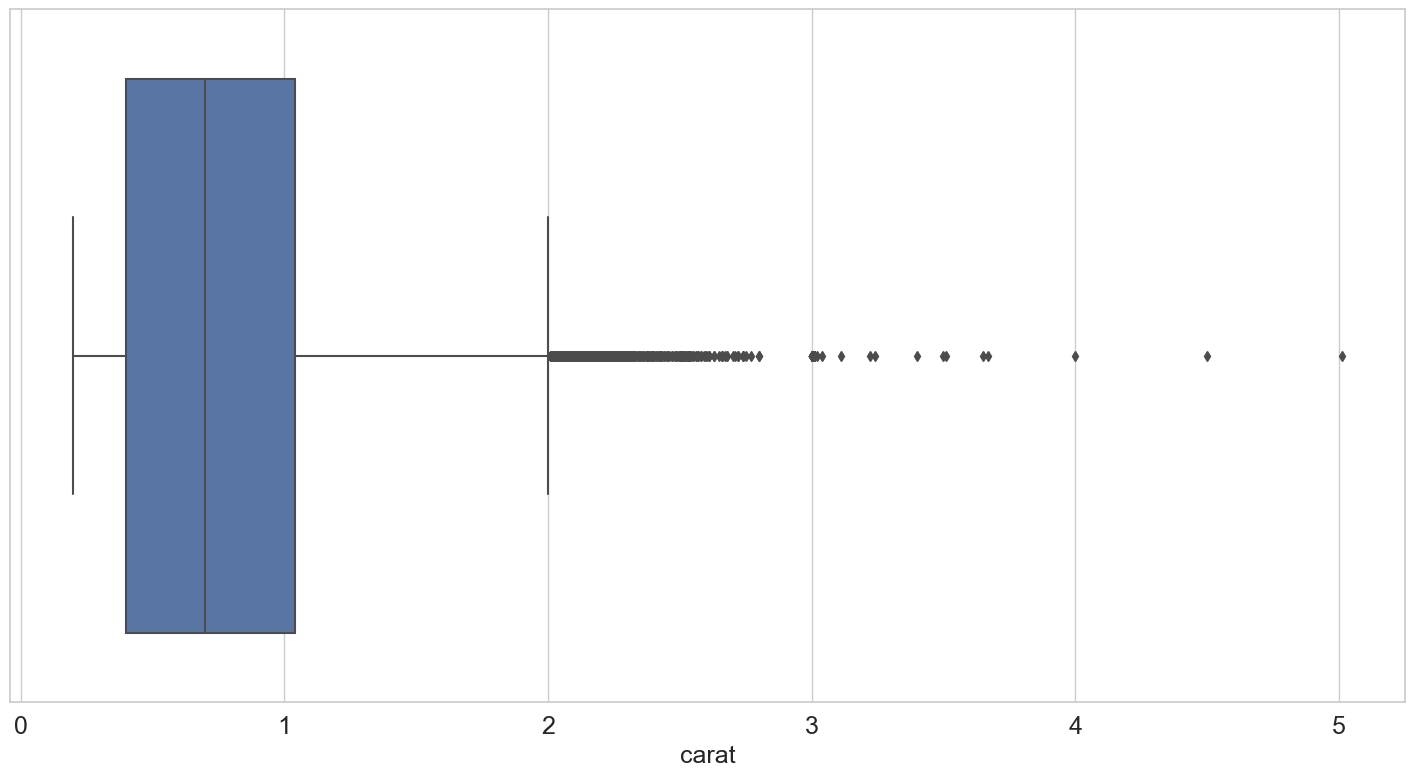

In [20]:
sns.boxplot(x=df_train.carat)

<AxesSubplot: xlabel='carat'>

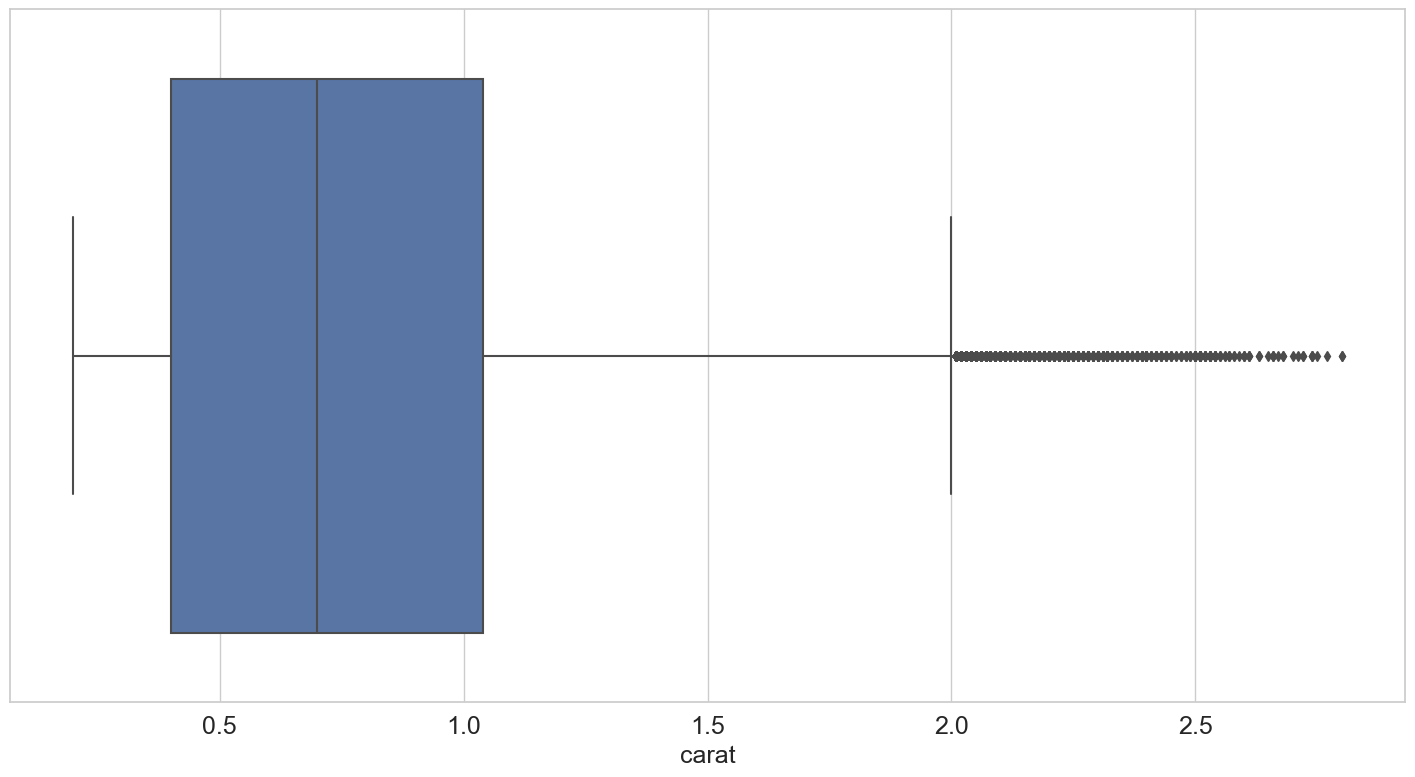

In [21]:
# The datapoints look less sparse
sns.boxplot(x=df_train[df_train.carat<3]['carat'])

In [22]:
#Dropping the outliers. Carat >=3
df_train = df_train[df_train["carat"]<3]

<AxesSubplot: xlabel='price'>

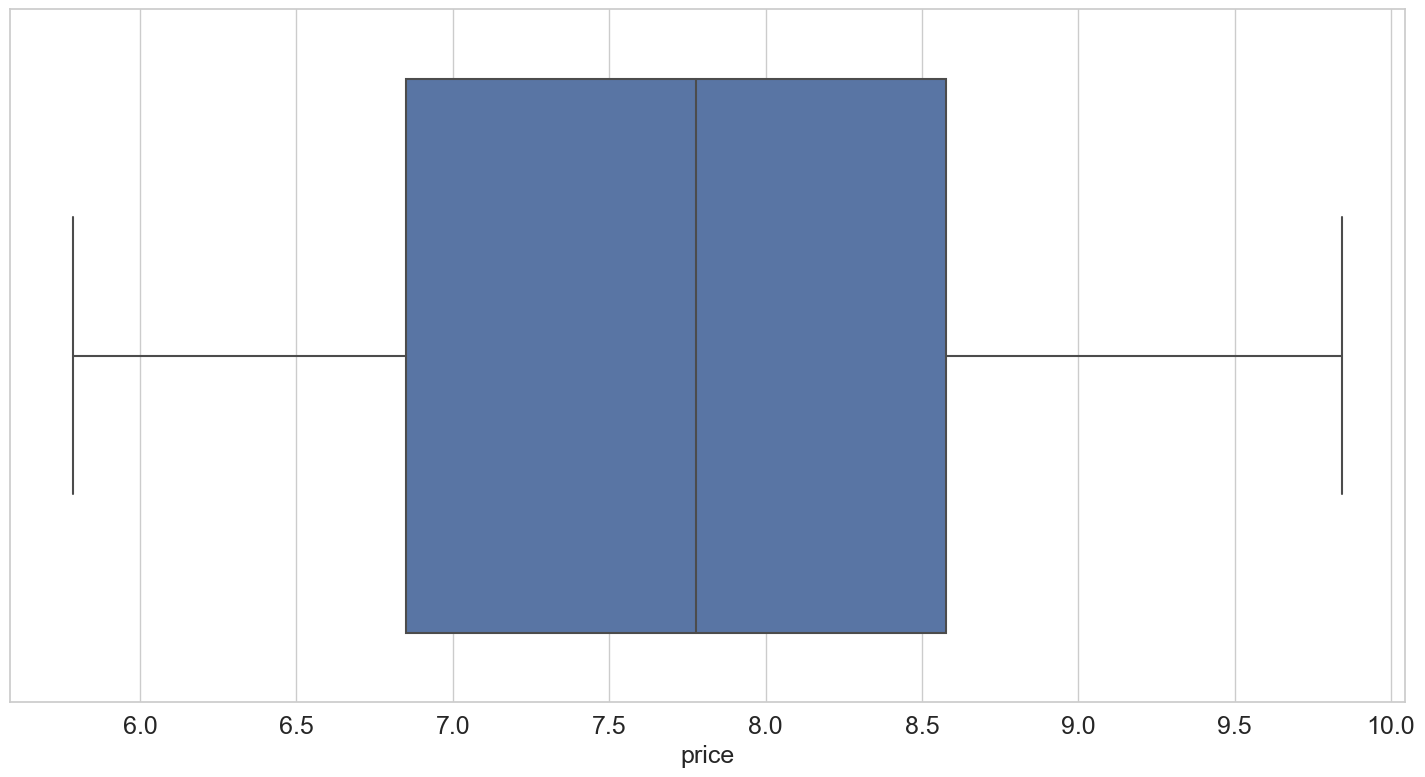

In [23]:
#No need to drop outliers as there are no outliers in price
sns.boxplot(x=df_train.price)

## Processing

Now that the dataset is cleaned for the model, processing the data is necessary, otherwise we won't be able to fit a model.

In [24]:
X = df_train.drop(columns=['price'])
y = df_train['price']

In [25]:
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [26]:
X = scaler.transform(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #randomstate=42

![](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/4_train-test-split.jpg)

## Train, test split

In [28]:
rf = RandomForestRegressor()
xgb = XGBRegressor()
xgbr = XGBRFRegressor()
linreg = LinearRegression()
trees = ExtraTreeRegressor()
knn = KNeighborsRegressor()
gb = GradientBoostingRegressor()
cat = CatBoostRegressor(verbose=0)
regressor = SVR(kernel = 'rbf')


models = [rf, xgb, xgbr, linreg, trees, knn, gb, cat, regressor]

In [29]:
linreg.fit(X_train,y_train)

LinearRegression()

In [30]:
reg_summary = pd.DataFrame(df_train.columns[:-1], columns=['Features'])
reg_summary['Weights'] = [linreg.coef_[i] for i in range(len(df_train.columns[:-1]))]
reg_summary = reg_summary.append({'Features':'Bias', 'Weights': linreg.intercept_}, ignore_index=True)
reg_summary

,Features,Weights
0,carat,1.408336
1,cut,0.029555
2,color,0.260731
3,clarity,0.182531
4,Bias,7.534569


We can see that the remaining variables are somewhat relevant except for cut, which will be left on the model for now.

In [31]:
train_preds = pd.DataFrame()

test_preds = pd.DataFrame()

eval_train = pd.DataFrame()

eval_test = pd.DataFrame()

for model in models:
    name = str(model)[:14]
    print(f'\nTraining ..... {name}\n')
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, train_pred, squared=False)
    test_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, test_pred, squared=False)
    
    model.fit(X,y)
    
    
    
    train_preds[f'{name}'] = train_pred
    test_preds[f'{name}'] = test_pred
    
    eval_train[f'{name}'] = rmse_train
    eval_test[f'{name}'] = rmse_test
    
    print(f'RMSE {name} on train: {rmse_train}')
    print(f'RMSE de {name} on test: {rmse_test}')


Training ..... RandomForestRe

RMSE RandomForestRe on train: 0.08124629841003794
RMSE de RandomForestRe on test: 0.10737749940982744

Training ..... XGBRegressor(b

RMSE XGBRegressor(b on train: 0.09387838863735191
RMSE de XGBRegressor(b on test: 0.10034253294698857

Training ..... XGBRFRegressor

RMSE XGBRFRegressor on train: 0.1516724382918438
RMSE de XGBRFRegressor on test: 0.1529114778034779

Training ..... LinearRegressi

RMSE LinearRegressi on train: 0.34015002979703046
RMSE de LinearRegressi on test: 0.3412777041371323

Training ..... ExtraTreeRegre

RMSE ExtraTreeRegre on train: 0.07891080778541477
RMSE de ExtraTreeRegre on test: 0.11563930989560059

Training ..... KNeighborsRegr

RMSE KNeighborsRegr on train: 0.10007446286613478
RMSE de KNeighborsRegr on test: 0.1175890746042999

Training ..... GradientBoosti

RMSE GradientBoosti on train: 0.10723541031011627
RMSE de GradientBoosti on test: 0.10672127825364269

Training ..... <catboost.core

RMSE <catboost.core on train: 0.09

In [32]:
df_test.sample()

,id,carat,cut,color,clarity
9365,9365,1.01,3,4,4


Applying same cleaning & processing to my `test.csv`

In [38]:
X=df_test.drop(columns='id')
scaler.fit(X)
X = scaler.transform(X)

# Predict on the `test.csv`

In [39]:
y_pred = cat.predict(X)
y_pred

array([6.09853901, 8.6002599 , 9.47192107, ..., 6.34833089, 8.66873589,
       7.98044509])

# DF with two columns

In [41]:
df_for_submission=pd.DataFrame({'id':df_test.id , 'price': y_pred })

In [42]:
print(df_for_submission.shape[0])
df_for_submission.sample()

13485


,id,price
6922,6922,6.407945


In [43]:
df_for_submission.to_csv("my_submission.csv", index=False)

In [67]:
rf = RandomForestRegressor()
xgb = XGBRegressor()
xgbr = XGBRFRegressor()
linreg = LinearRegression()
trees = ExtraTreeRegressor()
knn = KNeighborsRegressor()
gb = GradientBoostingRegressor()
cat = CatBoostRegressor(verbose=0)
regressor = SVR(kernel = 'rbf')


models = [rf, xgb, xgbr, linreg, trees, knn, gb, cat, regressor]

In [85]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [86]:
df_train['volume'] = df_train['x']*df_train['y']*df_train['z']
df_train.drop(['x', 'y', 'z'], axis=1, inplace=True)
df_train.head()

,id,carat,cut,color,clarity,depth,table,price,volume
0,0,0.30,Premium,D,SI2,62.4,58.0,6.353,49.437424
1,1,1.01,Ideal,E,VVS2,62.7,56.0,9.183,167.551728
2,2,0.72,Ideal,F,VS2,61.8,59.0,7.983,116.024916
3,3,1.08,Very Good,G,SI2,63.2,57.0,8.371,175.141200
4,4,0.36,Premium,G,VS1,62.3,59.0,6.588,57.739500


In [87]:
df_test['volume'] = df_test['x']*df_test['y']*df_test['z']
df_test.drop(['x', 'y', 'z'], axis=1, inplace=True)
df_test.head()

,id,carat,cut,color,clarity,depth,table,volume
0,0,0.32,Ideal,I,SI1,60.5,58.0,53.70489
1,1,1.24,Premium,I,SI1,62.9,60.0,195.24432
2,2,1.66,Premium,D,SI1,62.0,59.0,269.68600
3,3,0.75,Premium,D,SI2,60.6,56.0,125.81514
4,4,1.50,Fair,E,SI2,64.8,55.0,242.41503


In [88]:
def outliers(df,var):
    a = []
    q1 = df[var].quantile(.25)
    q2 = df[var].quantile(.5)
    q3 = df[var].quantile(.75)
    iqr = q3-q1
    ulim = float(q3+(1.5*iqr))
    llim = float(q1-(1.5*iqr))

    for i in df[var]:
        if i > ulim:
            i = np.NaN
        elif i < llim:
            i = np.NaN
        else:
            i=i
        a.append(i)
    return a

In [89]:
for col in df_train.select_dtypes(exclude='object').columns:
    df_train[col] = outliers(df_train,col)
    
for i in df_train.select_dtypes(exclude='object').columns:
    df_train[i] = df_train[i].fillna(df_train[i].mean())

In [90]:
for col in df_test.select_dtypes(exclude='object').columns:
    df_test[col] = outliers(df_test,col)

for i in df_test.select_dtypes(exclude='object').columns:
    df_test[i] = df_test[i].fillna(df_test[i].mean())

In [74]:
numerical_cols = df_train.select_dtypes(include=np.number).columns.to_list()
categorical_cols = df_train.select_dtypes(exclude=np.number).columns.to_list()

In [75]:
numerical_cols

['id', 'carat', 'depth', 'table', 'price', 'volume']

In [76]:
categorical_cols

['cut', 'color', 'clarity']

In [91]:
df_train.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
volume     0
dtype: int64

In [92]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 

df_train['cut'] = label_encoder.fit_transform(df_train['cut'])
df_train['color'] = label_encoder.fit_transform(df_train['color'])
df_train['clarity'] = label_encoder.fit_transform(df_train['clarity'])
df_train.head()

,id,carat,cut,color,clarity,depth,table,price,volume
0,0,0.30,3,0,3,62.4,58.0,6.353,49.437424
1,1,1.01,2,1,7,62.7,56.0,9.183,167.551728
2,2,0.72,2,2,5,61.8,59.0,7.983,116.024916
3,3,1.08,4,3,3,63.2,57.0,8.371,175.141200
4,4,0.36,3,3,4,62.3,59.0,6.588,57.739500


In [93]:
df_test['cut'] = label_encoder.fit_transform(df_test['cut'])
df_test['color'] = label_encoder.fit_transform(df_test['color'])
df_test['clarity'] = label_encoder.fit_transform(df_test['clarity'])
df_test.head()

,id,carat,cut,color,clarity,depth,table,volume
0,0,0.32,2,5,2,60.500000,58.0,53.70489
1,1,1.24,3,5,2,62.900000,60.0,195.24432
2,2,1.66,3,0,2,62.000000,59.0,269.68600
3,3,0.75,3,0,3,60.600000,56.0,125.81514
4,4,1.50,0,1,3,61.795222,55.0,242.41503


In [94]:
X = df_train.drop(['price'],1)
y = df_train['price']

In [95]:
X.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
volume     0
dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=142)

In [100]:
rf  = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("RMSE: {}".format(np.sqrt(mean_squared_error((y_test),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((y_test),(y_pred)))))

RMSE: 0.11231869962092196
R2  : 0.9938559874241413


In [101]:
n_estimators = [int(x) for x in np.linspace(10,200,10)]
max_depth = [int(x) for x in np.linspace(10,100,10)]
min_samples_split = [2,3,4,5,10]
min_samples_leaf = [1,2,4,10,15,20]
random_grid = {'n_estimators':n_estimators,'max_depth':max_depth,
               'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

random_grid

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 3, 4, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10, 15, 20]}

In [103]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               cv = 3)

rf_random.fit(X_train,y_train)
y_pred = rf_random.predict(X_test)

print("RMSE: {}".format(np.sqrt(mean_squared_error((y_test),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((y_test),(y_pred)))))

RMSE: 0.11216541068288977
R2  : 0.9938727979401071


In [104]:
rf_random.best_params_

{'n_estimators': 115,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 80}

In [105]:
rf = RandomForestRegressor(n_estimators=73,
                         min_samples_split=3,
                         min_samples_leaf=4,
                         max_depth=40)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("RMSE: {}".format(np.sqrt(mean_squared_error((y_test),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((y_test),(y_pred)))))

RMSE: 0.1126076863088015
R2  : 0.9938242323247723


In [107]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state = 42)

In [ ]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("RMSE: {}".format(np.sqrt(mean_squared_error((y_test),(y_pred)))))
print("R2  : {}".format(np.sqrt(r2_score((y_test),(y_pred)))))

In [108]:
X_train

,id,carat,cut,color,clarity,depth,table,volume
33878,33878,0.30,4,4,1,62.3,56.0,49.898920
9248,9248,1.55,4,3,3,61.9,60.0,244.259264
3020,3020,0.72,3,0,4,62.7,56.0,117.660096
26529,26529,1.52,3,5,4,60.6,57.0,253.111032
22679,22679,0.70,3,2,7,61.0,57.0,116.244180
...,...,...,...,...,...,...,...,...
40204,40204,0.53,2,2,4,61.6,55.0,87.907288
12799,12799,0.40,4,3,3,63.1,59.0,64.472250
31131,31131,0.50,4,2,2,60.0,54.0,82.695600
40133,40133,0.40,2,0,5,61.5,55.0,65.103975


In [109]:
df_test

,id,carat,cut,color,clarity,depth,table,volume
0,0,0.32,2,5,2,60.500000,58.0,53.704890
1,1,1.24,3,5,2,62.900000,60.0,195.244320
2,2,1.66,3,0,2,62.000000,59.0,269.686000
3,3,0.75,3,0,3,60.600000,56.0,125.815140
4,4,1.50,0,1,3,61.795222,55.0,242.415030
...,...,...,...,...,...,...,...,...
13480,13480,1.10,3,3,2,59.600000,60.0,180.632000
13481,13481,0.90,4,0,2,62.100000,60.0,145.800440
13482,13482,0.30,2,2,5,62.100000,53.3,49.783680
13483,13483,1.25,2,5,2,59.600000,59.0,208.743780


In [111]:
y_pred = rf.predict(df_test)

In [112]:
y_pred

array([6.16527267, 8.61255617, 9.49287617, ..., 6.452632  , 8.60081784,
       8.01712677])

In [113]:
df_test['price'] = y_pred # Adding the predicted price
df_for_submission = df_test[["id", "price"]] # Modifying for subnmission

In [114]:

print(df_for_submission.shape[0])
df_for_submission.sample()

13485


,id,price
2142,2142,7.664529


In [115]:
df_for_submission.to_csv("my_submission.csv", index=False)

In [118]:
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_pred = tree_reg.predict(df_test)

In [119]:
y_pred = tree_reg.predict(df_test.drop(columns='price'))

In [120]:
y_pred

array([6.317, 8.559, 9.292, ..., 6.399, 8.686, 8.045])

In [121]:
df_test['price'] = y_pred # Adding the predicted price
df_for_submission = df_test[["id", "price"]] # Modifying for subnmission

In [122]:
df_for_submission.sample()

,id,price
8872,8872,6.65


In [123]:
df_for_submission.to_csv("my_submission.csv", index=False)

In [49]:
# df_train_cleaned = df_train.select_dtypes(exclude='object')
# df_test_cleaned = df_test.select_dtypes(exclude='object')